In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.stats import norm, multivariate_normal

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## The Model

We assume that we have 50 $x$ and $y$ samples from a $N(0, 1)$ distribution. The exact data model is:
$$
\begin{align*}
    x_i     & \sim N(\mu_x, 1) \\
    y_i     & \sim N(\mu_y, 1) \\
    \mu_x   & \sim N(0, 0.5) \\
    \mu_y   & \sim N(0, 0.5)
\end{align*}
$$

## Hamiltonian Monte Carlo

HMC requires five things:

1. The negative log-probability $U$ of the data in the current position.

$$
   U = -\left ( \sum_i \log p(y_i \mid \mu_y, 1) + \sum_i \log p(x_i \mid \mu_x, 1) 
            + \log p(\mu_y \mid 0, 0.5) + \log p(\mu_x \mid 0, 0.5)\right )
$$

In the current setting, $p(x \mid a, b)$ is the pdf of the Normal distribution with mean $a$ and standard deviation $b$.

In [2]:
N_SAMPLES = 50

rv = norm(loc=0, scale=1)
x = rv.rvs(size=N_SAMPLES)
y = rv.rvs(size=N_SAMPLES)

### Code 9.5

In [3]:
def calc_U(x, y, q, a=0, b=0.5, c=0, d=0.5):
    mu_x, mu_y = q
    
    U = np.sum(norm.logpdf(y, loc=mu_y, scale=1) + 
               norm.logpdf(x, loc=mu_x, scale=1) + 
               norm.logpdf(mu_y, loc=a, scale=b) + 
               norm.logpdf(mu_x, loc=c, scale=d))
    return -U

In [4]:
calc_U(x, y, q=[0.1, 0.2])

183.02932251649966

2. A gradient function that returns the gradient of the negative log-probability of the data in the current position. 

Since $p(y \mid a, b)$ is the pdf of the Normal distribution with mean $a$ and standard deviation $b$, we have:
$$
    \log p(y \mid a, b) = \log \frac{1}{\sqrt{2 \pi} b} - \frac{1}{2 b^2} (y - a)^2.
$$
The partial derivative wrt $a$ is:
$$
    \frac{\partial \log p(y \mid a, b)}{\partial a} = \frac{y - a}{b^2}.
$$
The partial derivative wrt $y$ is:
$$
    \frac{\partial \log p(y \mid a, b)}{\partial y} = - \frac{y - a}{b^2}.
$$

Therefore $\partial U / \partial \mu_x$ is given by:
$$
    \frac{\partial U}{\partial \mu_x} = 
        \sum_i \frac{\partial p(x_i \mid \mu_x, 1)}{\partial \mu_x} + 
        \frac{\partial p(\mu_x \mid 0, 0.5)}{\partial \mu_x} =
        \sum_i \frac{(x_i - \mu_x)}{1^2} - \frac{\mu_x - 0}{0.5^2}.
$$

Similarly, $\partial U / \partial \mu_y$ is given by:
$$
    \frac{\partial U}{\partial \mu_y} = 
        \sum_i \frac{\partial p(y_i \mid \mu_y, 1)}{\partial \mu_y} + 
        \frac{\partial p(\mu_y \mid 0, 0.5)}{\partial \mu_y} =
        \sum_i \frac{(y_i - \mu_y)}{1^2} - \frac{\mu_y - 0}{0.5^2}.
$$

In [5]:
def grad_U(x, y, q, a=0, b=0.5, c=0, d=0.5):
    mu_x = q[0]
    mu_y = q[1]

    grad_mu_x = np.sum(x - mu_x) - (mu_x - a) / b**2
    grad_mu_y = np.sum(y - mu_y) - (mu_y - c) / d**2
    
    return np.array([-1 * grad_mu_x, -1 * grad_mu_y])

In [6]:
grad_U(x, y, q=[0.1, 0.2])

array([11.38276042,  9.00427394])

3. a step-size `epsilon`

4. a count of leapfrog steps $L$

5. a starting position `current_q`

### HMC2 Function Code 9.8, 9.9, 9.10

Credit: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_09.ipynb

In this context, we need to recall a few facts from Physics. We assume that the particle whose motion we will simulate has a mass of $1$ unit. The momentum of this particle is therefore equal to its velocity. Also recall that force is the _negative_ derivative of the potential energy wrt the position. In our case:

$$
    \mathbf{F} = - \left [
        \begin{array}{cc} 
            \frac{\partial U}{\partial \mu_x} \\
            \frac{\partial U}{\partial \mu_x}
        \end{array}
               \right ]
$$

This is what `grad_U` calculates. The other point to note is that force multiplied by the time for which it acts, yields the change in momentum. That is:
$$
    \int_{t_1}^{t_2} \mathbf{F} \cdot dt = m \int_{t_1}^{t_2} \mathbf{a} \cdot dt = m \mathbf{v}_2 - m \mathbf{v}_1.
$$

Therefore given the current momentum $\mathbf{p}_{\text{curr}}$ of the particle, the change in momenetum after time $\epsilon$ is $- \epsilon \cdot \nabla U$. If $\mathbf{q}_{\text{curr}}$ is its current position, its final momentum and position are given by:
$$
\begin{align*}
  \mathbf{p}_{\text{new}} & = \mathbf{p}_{\text{curr}} - \epsilon \cdot \nabla U \\
  \mathbf{q}_{\text{new}} & = \mathbf{q}_{\text{curr}} + \epsilon \cdot \mathbf{p}_{\text{curr}}.
\end{align*}
$$
In the last equation, $\mathbf{p}_{\text{curr}}$ is also the velocity of the particle (as its mass = $1$).

In [7]:
from typing import Callable


def HMC2(U: Callable, grad_U: Callable, epsilon: float, L: int, current_q: np.array, x: np.array, y: np.array):
    """
        This function runs a single trajectory and produces one sample. To build a chain of samples, 
        call this function repeatedly.
    """
    q = current_q
    # random flick - p is momentum; p = m * v, and we assume a mass m = 1 unit
    p = np.random.normal(loc=0, scale=2, size=len(q))  
    current_p = p
    
    # Make a half step for momentum at the beginning
    p = p - 0.5 * epsilon * grad_U(x, y, q) 
    
    # initialize bookkeeping - saves trajectory
    q_traj = np.full(shape=(L + 1, len(q)), fill_value=np.nan)
    p_traj = q_traj.copy()
    
    q_traj[0, :] = current_q
    p_traj[0, :] = p

    # Code 9.9 starts here
    for i in range(1, L + 1):
        # Think of epsilon as a time step. 
        # Then the next position = current pos + velocity * time = q + p * epsilon
        q = q + epsilon * p 
        q_traj[i, :] = q
        
        # Make a full step for the momentum, except at the end of trajectory
        if i != L - 1:
            # grad_U is the derivative of the PE wrt position.  
            # Force = - grad_U
            # time * force = change in momentum
            p = p - epsilon * grad_U(x, y, q)
            p_traj[i, :] = p

    # Make a half step for momentum at the end
    p = p - 0.5 * epsilon * grad_U(x, y, q)
    p_traj[L, :] = p
    
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -1 * p
    
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(x, y, current_q)
    # mass = 1 unit so that KE = 0.5 * p**2
    current_K = np.sum(current_p ** 2) / 2.0
    
    proposed_U = U(x, y, q)
    proposed_K = np.sum(p ** 2) / 2.0
    
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = False
    criterion = np.exp(current_U - proposed_U + current_K - proposed_K)
    if np.random.uniform() < criterion:
        # accept
        new_q = q  
        accept = True
    else:
        # reject
        new_q = current_q  

    return dict(q=new_q, traj=q_traj, p_traj=p_traj, accept=accept)

### Code 9.7

Credit: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_09.ipynb

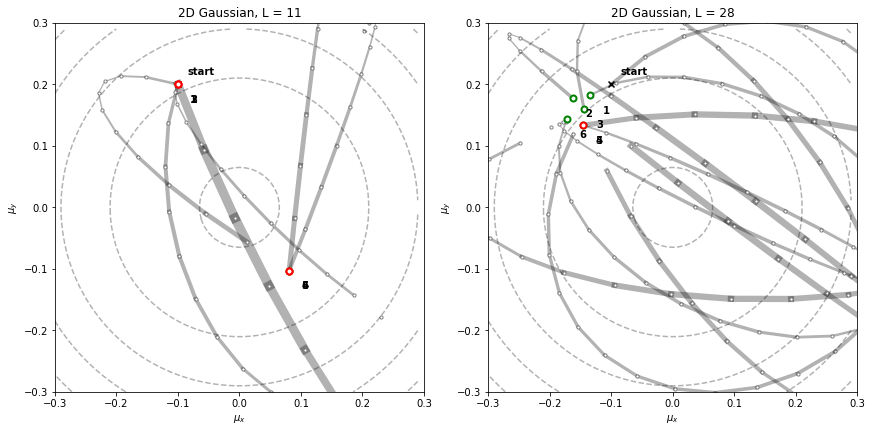

In [8]:
np.random.seed()

# test data
real = multivariate_normal([0, 0], np.identity(2))
x, y = real.rvs(50).T

_, axs = plt.subplots(1, 2, figsize=[12, 12], constrained_layout=True)

pr = 0.3
step = 0.03
n_samples = 6

# L = 11  # 0.03 / 28 for U-turns -- 11 for working example
for L, ax in zip([11, 28], axs):
    Q = dict(q=np.array([-0.1, 0.2]))    
    ax.scatter(*Q['q'], color='k', marker='x', zorder=3)
    ax.text(*Q['q'] + 0.015, 'start', weight='bold')
    
    for i in range(n_samples):
        Q = HMC2(calc_U, grad_U, step, L, Q['q'], x, y)
        
        if Q['accept']:
            col = 'g'
        else:
            col = 'r'
            
        ax.scatter(*Q['q'], color='w', marker='o', edgecolor=col, lw=2, zorder=3)
        
        if n_samples < 200:
            for j in range(L):
                K0 = np.sum(Q['p_traj'][j, :] ** 2) / 2  # kinetic energy
                ax.plot(Q['traj'][j : j + 2, 0], Q['traj'][j : j + 2, 1], 
                        color='k', lw=1 + 1 * K0, alpha=0.3, zorder=1)
            
            ax.scatter(*Q['traj'].T, facecolor='w', edgecolor='gray', lw=1, zorder=2, s=10)
            ax.text(*Q['q'] + [0.02, -0.03], f'{i + 1}', weight="bold")

    ax.set_title(f'2D Gaussian, L = {L}')
    ax.set_xlabel(r'$\mu_x$')
    ax.set_ylabel(r'$\mu_y$')

    # draw background contours based on real probability defined above
    lim = 1.0 * pr
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    xs, ys = np.mgrid[-lim:lim:0.01, -lim:lim:0.01]
    
    p = real.logpdf(np.vstack([xs.flat, ys.flat]).T).reshape(xs.shape)
    ax.contour(xs, ys, p, 4, colors=[(0, 0, 0, 0.3)])
    ax.set_aspect(1)

### Fig 9.6 Bottom Panel

Credit: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_09.ipynb

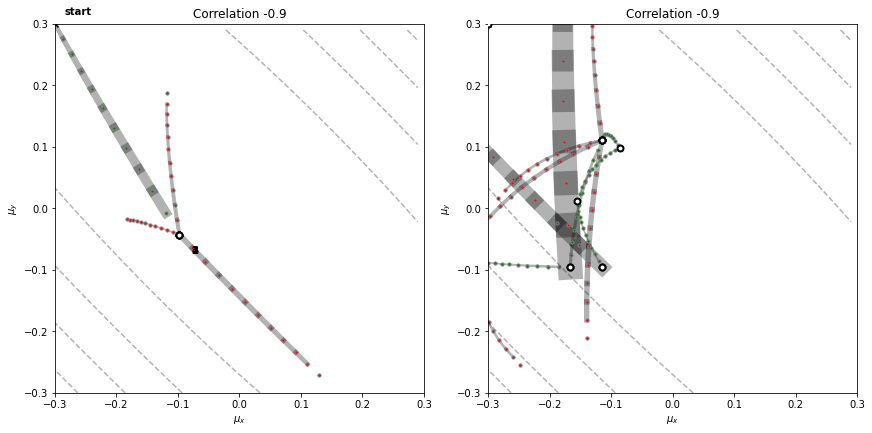

In [9]:
# Figure 9.6 (bottom row) with correlated data

np.random.seed()

# test data
realc = multivariate_normal([0, 0], [[1, -0.9], [-0.9, 1]])  # generate correlated data
x, y = real.rvs(50).T

pr = 0.3
step = 0.01
L = 11  # 28 for U-turns -- 11 for working example

_, axs = plt.subplots(1, 2, figsize=[12, 12], constrained_layout=True)

for n_samples, ax in zip([4, 15], axs):
    Q = dict(q=np.array([-0.3, 0.3]))

    ax.scatter(*Q['q'], color='k', marker='x', zorder=3)
    
    if n_samples == 4:
        ax.text(*Q['q'] + 0.015, 'start', weight='bold')
        
    for i in range(n_samples):
        Q = HMC2(calc_U, grad_U, step, L, Q['q'], x, y)
        ax.scatter(*Q['q'], color='w', marker='o', edgecolor='k', lw=2, zorder=3)
        
        if n_samples < 100:
            for j in range(L):
                K0 = np.sum(Q['p_traj'][j, :] ** 2) / 2  # kinetic energy
                ax.plot(Q['traj'][j : j + 2, 0], Q['traj'][j : j + 2, 1],
                        color='k', lw=1 + 1 * K0, alpha=0.3, zorder=1)
                
            if Q['accept']:
                c = 'g'
            else:
                c = 'r'
            ax.scatter(*Q['traj'].T, facecolor=c, edgecolor='gray', lw=1, zorder=2, s=10)
            
            if n_samples == 4:
                ax.text(*Q['q'] + [0.02, -0.03], f'{i + 1}', weight="bold")

    ax.set_title(f'Correlation -0.9')
    ax.set_xlabel(r'$\mu_x$')
    ax.set_ylabel(r'$\mu_y$')

    # draw background contours based on real probability defined above
    lim = 1.0 * pr
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    xs, ys = np.mgrid[-lim:lim:0.01, -lim:lim:0.01]
    p = realc.logpdf(np.vstack([xs.flat, ys.flat]).T).reshape(xs.shape)
    ax.contour(xs, ys, p, 5, colors=[(0, 0, 0, 0.3)])
    ax.set_aspect(1);